# サマタ瞑想のfmシータ波分析

このノートブックでは、サマタ瞑想中の前頭部ミッドラインシータ波（fmシータ）を詳細に分析します。

## 前提

このノートブックは [mind_monitor_basic_analysis.ipynb](mind_monitor_basic_analysis.ipynb) の続きです。
基本分析で前処理済みのデータを使用します。

## fmシータ波とは？

- **周波数**: 4-8 Hz（シータ波帯域）
- **位置**: 前頭部正中線（Fz、FCz付近）
- **特徴**: 集中的な注意、瞑想の深まりと相関
- **Museでの測定**: AF7/AF8は前頭部外側だが、fmシータの影響を受ける可能性
- **科学的背景**: 長期瞑想者ほどfmシータが顕著（Aftanas & Golocheikine, 2001など）

## 目次

1. データの読み込みと前処理
2. シータ波パワーの時間推移と瞑想深度
3. シータ波の周波数詳細分析

## 関連ノートブック

- [mind_monitor_basic_analysis.ipynb](mind_monitor_basic_analysis.ipynb) - 基本分析
- [laterality_analysis.ipynb](laterality_analysis.ipynb) - 左右半球差分析

## 1. データの読み込みと前処理

まず、基本分析と同様にデータを読み込みます。

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mne
from IPython.display import display

%matplotlib inline

# 日本語フォント設定
plt.rcParams['font.family'] = 'Noto Sans CJK JP'
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
# データファイルのパス
DATA_PATH = Path('../data/samples/mindMonitor_2025-10-17--15-57-54_1095381020592657976.csv')
print(f'Loading: {DATA_PATH}')

# CSVを読み込み
df = pd.read_csv(DATA_PATH)

# タイムスタンプを日時型に変換
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'], errors='coerce')
df = df.dropna(subset=['TimeStamp']).sort_values('TimeStamp').reset_index(drop=True)

# データの先頭を確認
display(df.head())
print(f'\nデータ形状: {df.shape[0]} 行 × {df.shape[1]} 列')
print(f'記録時間: {df["TimeStamp"].min()} ~ {df["TimeStamp"].max()}')
print(f'計測時間: {(df["TimeStamp"].max() - df["TimeStamp"].min()).total_seconds():.1f} 秒')

Loading: ../data/samples/mindMonitor_2025-10-26--08-32-20_1403458594426768660.csv


/tmp/ipykernel_27150/2195548156.py:6: DtypeWarning: Columns (58) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH)


,TimeStamp,Delta_TP9,Delta_AF7,Delta_AF8,Delta_TP10,Theta_TP9,Theta_AF7,Theta_AF8,Theta_TP10,Alpha_TP9,...,Optics15,Optics16,Heart_Rate,HeadBandOn,HSI_TP9,HSI_AF7,HSI_AF8,HSI_TP10,Battery,Elements
0,2025-10-26 08:32:21.081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/muse/event/connected MuseS-FA35
1,2025-10-26 08:32:21.091,0.640006,0.831525,0.58542,0.828409,0.278927,0.716158,0.513055,0.447438,0.484576,...,0.0,0.0,59.055595,1.0,1.0,1.0,1.0,1.0,98.51,NaN
2,2025-10-26 08:32:21.095,0.640006,0.831525,0.58542,0.828409,0.278927,0.716158,0.513055,0.447438,0.484576,...,0.0,0.0,59.055595,1.0,1.0,1.0,1.0,1.0,98.51,NaN
3,2025-10-26 08:32:21.148,0.640006,0.831525,0.58542,0.828409,0.278927,0.716158,0.513055,0.447438,0.484576,...,0.0,0.0,59.029500,1.0,1.0,1.0,1.0,1.0,98.51,NaN
4,2025-10-26 08:32:21.148,0.640006,0.831525,0.58542,0.828409,0.278927,0.716158,0.513055,0.447438,0.484576,...,0.0,0.0,59.029500,1.0,1.0,1.0,1.0,1.0,98.51,NaN



データ形状: 377893 行 × 59 列
記録時間: 2025-10-26 08:32:21.081000 ~ 2025-10-26 08:57:31.748000
計測時間: 1510.7 秒


In [3]:
bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
summary_rows = []

for band in bands:
    cols = [c for c in df.columns if c.startswith(f'{band}_')]
    if not cols:
        continue
    
    numeric = df[cols].apply(pd.to_numeric, errors='coerce')
    numeric = numeric.replace(0.0, np.nan)  # ゼロは欠損として扱う
    
    summary_rows.append({
        'バンド': band,
        '平均値': numeric.stack().mean(),
        '標準偏差': numeric.stack().std(),
        '有効データ率 (%)': numeric.notna().stack().mean() * 100,
    })

summary_df = pd.DataFrame(summary_rows)
display(summary_df.style.format({
    '平均値': '{:.4f}',
    '標準偏差': '{:.4f}',
    '有効データ率 (%)': '{:.2f}'
}))

,バンド,平均値,標準偏差,有効データ率 (%)
0,Delta,0.1100,0.4865,99.07
1,Theta,-0.0241,0.4339,99.07
2,Alpha,0.4503,0.5383,99.07
3,Beta,-0.0257,0.3022,99.07
4,Gamma,-0.1752,0.3808,99.07


In [4]:
# RAWチャネルの検出
raw_cols = [c for c in df.columns if c.startswith('RAW_')]

# MNE用にRAWデータを準備
if raw_cols:
    # 数値変換と前処理
    numeric = df[raw_cols].apply(pd.to_numeric, errors='coerce')
    frame = pd.concat([df['TimeStamp'], numeric], axis=1)
    frame = frame.set_index('TimeStamp')
    
    # 重複タイムスタンプは平均化
    frame = frame.groupby(level=0).mean()
    
    # 時間補間で欠損値を埋める
    frame = frame.interpolate(method='time').ffill().bfill()
    
    # サンプリングレートの推定
    diffs = frame.index.to_series().diff().dropna()
    dt_seconds = diffs.median().total_seconds()
    sfreq = 1.0 / dt_seconds if dt_seconds > 0 else 256.0
    
    # MNE RawArrayの作成
    ch_names = list(frame.columns)
    ch_types = ['eeg'] * len(ch_names)
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    
    # μVスケールをVに変換
    data = frame.to_numpy().T * 1e-6
    
    raw = mne.io.RawArray(data, info, copy='auto', verbose=False)
    
    # DCドリフト軽減のためのハイパスフィルタ
    if sfreq > 2.0:
        raw = raw.filter(l_freq=1.0, h_freq=None, fir_design='firwin', verbose=False)
    
    print(f'検出されたチャネル: {ch_names}')
    print(f'推定サンプリングレート: {sfreq:.2f} Hz')
    print(f'サンプル数: {len(frame)}')
else:
    print('RAWチャネルが見つかりません')

検出されたチャネル: ['RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10']
推定サンプリングレート: 333.33 Hz
サンプル数: 73743


## 7.7 サマタ瞑想とfmシータ波の分析

サマタ瞑想（集中瞑想）では、深い状態になると**fmシータ波（frontal midline theta）**が出現することが知られています。

### fmシータ波とは？

- **周波数**: 4-8 Hz（シータ波帯域）
- **位置**: 前頭部正中線（Fz、FCz付近）
- **特徴**: 集中的な注意、瞑想の深まりと相関
- **Museでの測定**: AF7/AF8は前頭部外側だが、fmシータの影響を受ける可能性

### 分析の観点

1. **前頭部シータ波のパワー増加**
2. **シータ/アルファ比率の上昇**（瞑想深度の指標）
3. **時間経過に伴うシータ波の増強**（瞑想の深まり）

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
分析時間範囲: 0秒 ~ 1467.8秒 (24.5分)


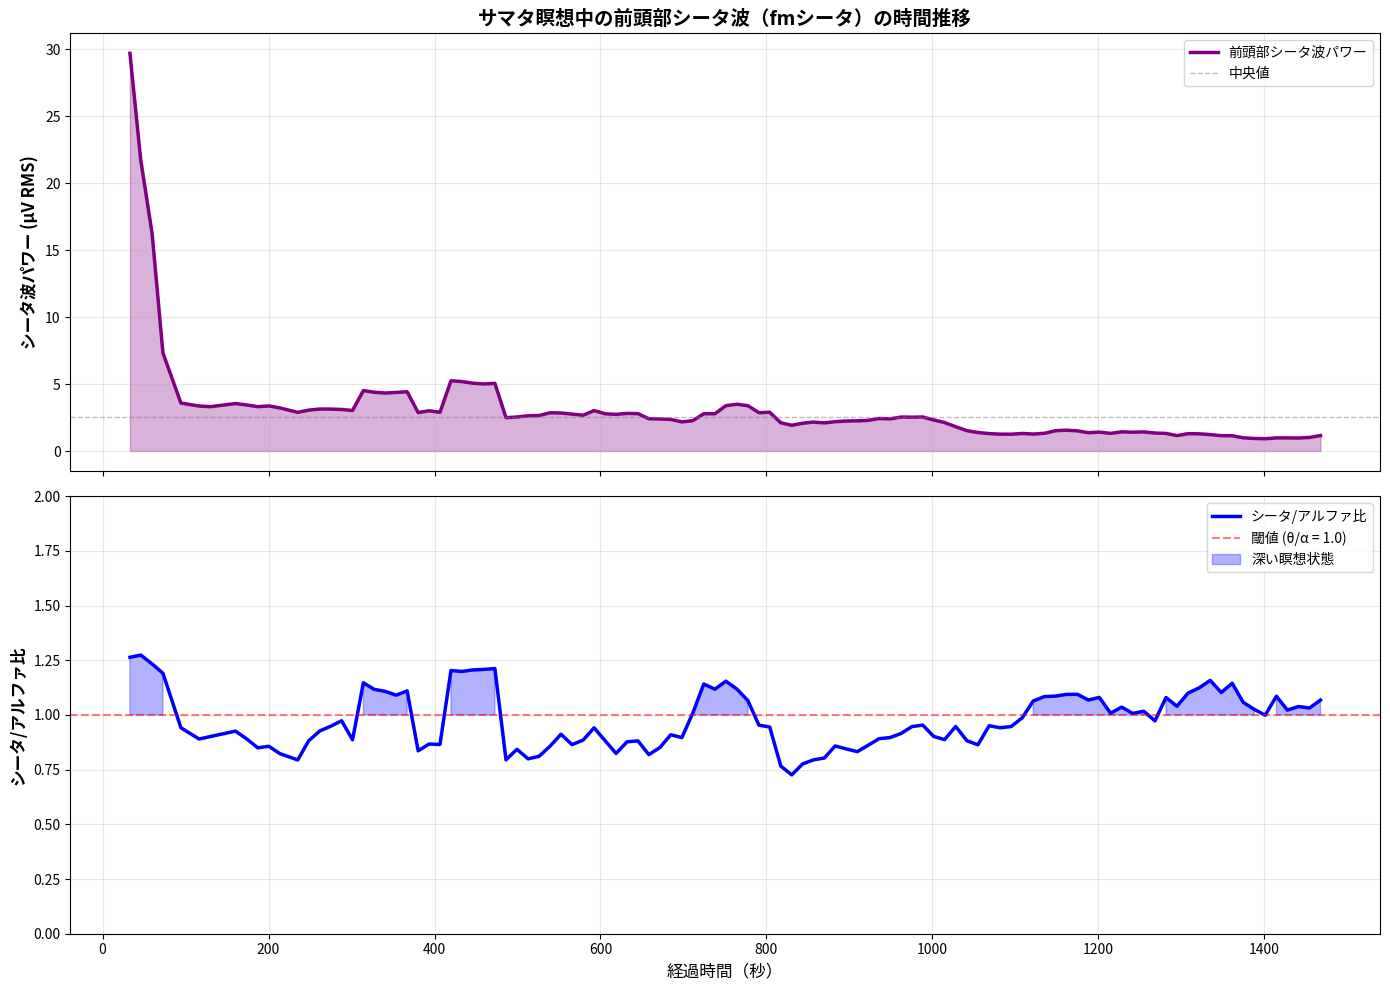


=== 前頭部シータ波（fmシータ）の統計 ===
シータ波パワー（平均）: 3.066 μV
シータ波パワー（最大）: 29.713 μV
シータ波パワー（中央値）: 2.507 μV

=== シータ/アルファ比（瞑想深度指標）===
平均比率: 0.978
最大比率: 1.274
中央比率: 0.948

深い瞑想状態（θ/α > 1.0）の時間割合: 42.5%

○ セッションの一部で深い瞑想状態に入っています

=== 瞑想の深まり（時間推移）===
前半のシータ/アルファ比: 0.978
後半のシータ/アルファ比: 0.978
変化: +0.000

○ 瞑想の深さは比較的一定です


In [7]:
# RAWデータから前頭部シータ波を詳細解析
if raw_cols and 'RAW_AF7' in raw.ch_names and 'RAW_AF8' in raw.ch_names:
    
    # 前頭部チャネルのみを抽出
    frontal_channels = ['RAW_AF7', 'RAW_AF8']
    raw_frontal = raw.copy().pick_channels(frontal_channels)
    
    # シータ波帯域（4-8 Hz）でフィルタリング
    raw_theta = raw_frontal.copy().filter(l_freq=4.0, h_freq=8.0, fir_design='firwin', verbose=False)
    
    # シータ波のパワー（RMS）を計算
    theta_power_af7 = np.sqrt(np.mean(raw_theta.get_data(picks='RAW_AF7')**2, axis=1))[0]
    theta_power_af8 = np.sqrt(np.mean(raw_theta.get_data(picks='RAW_AF8')**2, axis=1))[0]
    
    # 時間窓ごとのシータパワーを計算（10秒ウィンドウ）
    window_size = int(10 * sfreq)  # 10秒
    hop_size = int(2 * sfreq)      # 2秒ごとに計算
    
    # 元のタイムスタンプから経過時間を計算
    start_time = frame.index[0]
    
    times_windowed = []
    theta_power_windowed = []
    theta_alpha_ratio_windowed = []
    
    for start in range(0, len(raw.times) - window_size, hop_size):
        end = start + window_size
        
        # 実際のタイムスタンプから経過時間を計算
        actual_idx = min(start + window_size // 2, len(frame) - 1)
        actual_time = frame.index[actual_idx]
        elapsed_seconds = (actual_time - start_time).total_seconds()
        
        # シータ波パワー（4-8 Hz）
        data_window = raw_frontal.get_data(start=start, stop=end)
        theta_window = raw_theta.get_data(start=start, stop=end)
        theta_rms = np.sqrt(np.mean(theta_window**2))
        
        # アルファ波パワー（8-13 Hz）も計算
        raw_alpha = raw_frontal.copy().filter(l_freq=8.0, h_freq=13.0, fir_design='firwin', verbose=False)
        alpha_window = raw_alpha.get_data(start=start, stop=end)
        alpha_rms = np.sqrt(np.mean(alpha_window**2))
        
        # シータ/アルファ比率
        ratio = theta_rms / alpha_rms if alpha_rms > 0 else np.nan
        
        times_windowed.append(elapsed_seconds)
        theta_power_windowed.append(theta_rms * 1e6)  # μV単位
        theta_alpha_ratio_windowed.append(ratio)
    
    # データフレーム化
    meditation_df = pd.DataFrame({
        '経過時間(秒)': times_windowed,
        'シータパワー(μV)': theta_power_windowed,
        'シータ/アルファ比': theta_alpha_ratio_windowed,
    })
    
    print(f'分析時間範囲: 0秒 ~ {meditation_df["経過時間(秒)"].max():.1f}秒 ({meditation_df["経過時間(秒)"].max()/60:.1f}分)')
    
    # プロット
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    
    # 上段: シータ波パワーの時間推移
    ax1.plot(meditation_df['経過時間(秒)'], meditation_df['シータパワー(μV)'], 
            color='purple', linewidth=2.5, label='前頭部シータ波パワー')
    ax1.axhline(y=meditation_df['シータパワー(μV)'].median(), 
               color='gray', linestyle='--', alpha=0.5, linewidth=1, label='中央値')
    ax1.fill_between(meditation_df['経過時間(秒)'], 
                     meditation_df['シータパワー(μV)'],
                     alpha=0.3, color='purple')
    ax1.set_ylabel('シータ波パワー (μV RMS)', fontsize=12, fontweight='bold')
    ax1.set_title('サマタ瞑想中の前頭部シータ波（fmシータ）の時間推移', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # 下段: シータ/アルファ比率（瞑想深度）
    ax2.plot(meditation_df['経過時間(秒)'], meditation_df['シータ/アルファ比'], 
            color='blue', linewidth=2.5, label='シータ/アルファ比')
    ax2.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, linewidth=1.5, 
               label='閾値 (θ/α = 1.0)')
    ax2.fill_between(meditation_df['経過時間(秒)'], 
                     meditation_df['シータ/アルファ比'], 1.0,
                     where=(meditation_df['シータ/アルファ比'] > 1.0),
                     alpha=0.3, color='blue', label='深い瞑想状態')
    ax2.set_ylabel('シータ/アルファ比', fontsize=12, fontweight='bold')
    ax2.set_xlabel('経過時間（秒）', fontsize=12)
    ax2.legend(loc='upper right', fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, max(meditation_df['シータ/アルファ比'].max() * 1.2, 2.0))
    
    plt.tight_layout()
    plt.show()
    
    # 統計情報
    print('\n=== 前頭部シータ波（fmシータ）の統計 ===')
    print(f'シータ波パワー（平均）: {meditation_df["シータパワー(μV)"].mean():.3f} μV')
    print(f'シータ波パワー（最大）: {meditation_df["シータパワー(μV)"].max():.3f} μV')
    print(f'シータ波パワー（中央値）: {meditation_df["シータパワー(μV)"].median():.3f} μV')
    print()
    
    print('=== シータ/アルファ比（瞑想深度指標）===')
    print(f'平均比率: {meditation_df["シータ/アルファ比"].mean():.3f}')
    print(f'最大比率: {meditation_df["シータ/アルファ比"].max():.3f}')
    print(f'中央比率: {meditation_df["シータ/アルファ比"].median():.3f}')
    
    # 深い瞑想状態の判定
    deep_meditation_mask = meditation_df['シータ/アルファ比'] > 1.0
    deep_meditation_pct = deep_meditation_mask.sum() / len(meditation_df) * 100
    print(f'\n深い瞑想状態（θ/α > 1.0）の時間割合: {deep_meditation_pct:.1f}%')
    
    if deep_meditation_pct > 50:
        print('\n✓ セッションの大半で深い瞑想状態が維持されています！')
    elif deep_meditation_pct > 20:
        print('\n○ セッションの一部で深い瞑想状態に入っています')
    else:
        print('\n△ 深い瞑想状態は限定的です')
    
    # 時間経過に伴う変化（瞑想の深まり）
    # 前半と後半を比較
    mid_point = len(meditation_df) // 2
    first_half_ratio = meditation_df['シータ/アルファ比'].iloc[:mid_point].mean()
    second_half_ratio = meditation_df['シータ/アルファ比'].iloc[mid_point:].mean()
    
    print(f'\n=== 瞑想の深まり（時間推移）===')
    print(f'前半のシータ/アルファ比: {first_half_ratio:.3f}')
    print(f'後半のシータ/アルファ比: {second_half_ratio:.3f}')
    print(f'変化: {second_half_ratio - first_half_ratio:+.3f}')
    
    if second_half_ratio > first_half_ratio * 1.2:
        print('\n✓ 時間とともに瞑想が深まっています（シータ波増強）')
    elif second_half_ratio < first_half_ratio * 0.8:
        print('\n△ 後半で瞑想の深さが浅くなっています')
    else:
        print('\n○ 瞑想の深さは比較的一定です')
        
else:
    print('RAWデータが見つかりません。前頭部シータ波の詳細分析ができません。')

### 7.8 シータ波の周波数詳細分析

シータ波帯域（4-8 Hz）の中でも、周波数によって意味が異なることがあります。
より詳細な周波数分布を確認してみましょう。

/tmp/ipykernel_27150/2807299627.py:60: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  theta_total = np.trapz(theta_psd, theta_freqs)
/tmp/ipykernel_27150/2807299627.py:61: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  alpha_total = np.trapz(alpha_psd, alpha_freqs)


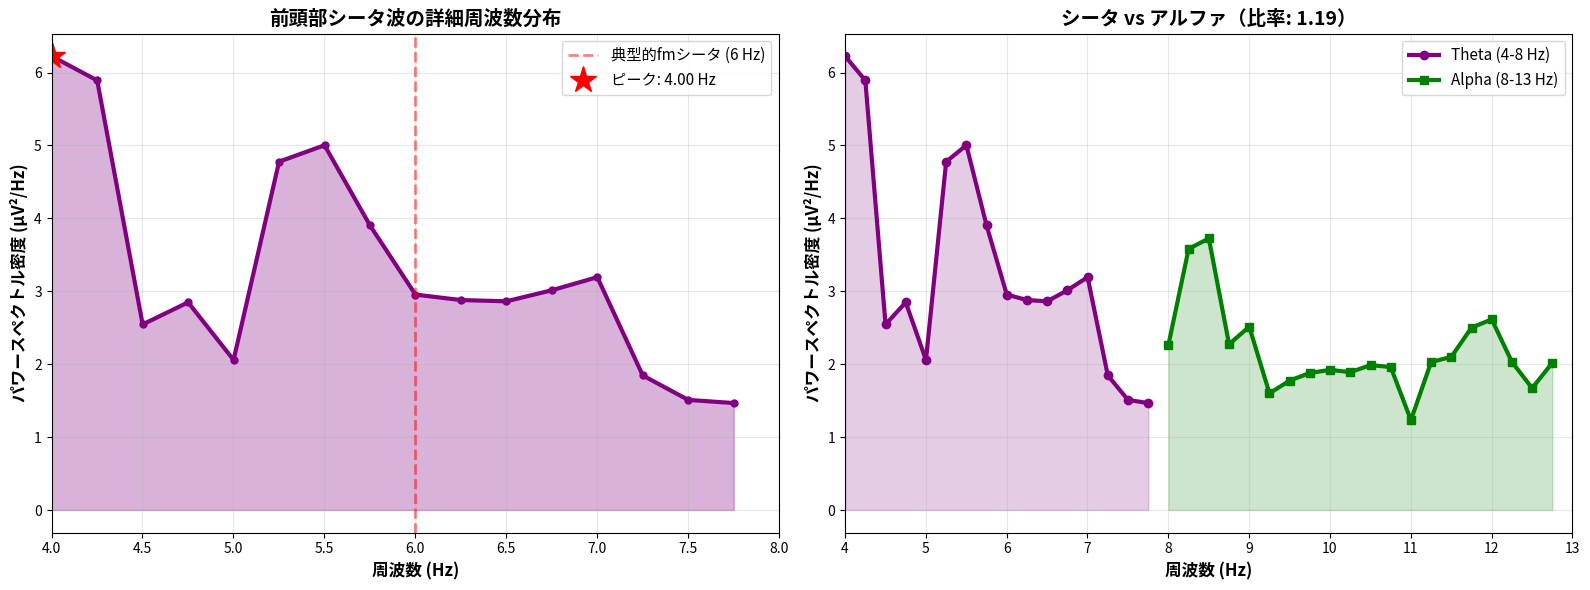


=== シータ波の周波数特性 ===
ピーク周波数: 4.00 Hz
ピークパワー: 6.22 μV²/Hz

fmシータ範囲（5-7 Hz）の総パワー: 6.23 μV²

シータ帯域総パワー: 12.29 μV²
アルファ帯域総パワー: 10.36 μV²
シータ/アルファ比（周波数積分）: 1.186

=== 瞑想状態の評価 ===
△ シータ波のピークが 4.0 Hz → やや低い
  深いリラックスまたは眠気の可能性

✓ シータ/アルファ比 = 1.19 > 1.0
  シータ波が優勢 → 深い瞑想状態の可能性が高い


/tmp/ipykernel_27150/2807299627.py:82: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  fm_theta_power = np.trapz(theta_psd[fm_theta_mask], theta_freqs[fm_theta_mask])


In [6]:
# シータ波帯域の詳細な周波数分析
if raw_cols and 'RAW_AF7' in raw.ch_names:
    
    # 前頭部チャネルの平均を計算（左右平均でミッドラインに近づける）
    frontal_avg = (raw.get_data(picks='RAW_AF7')[0] + raw.get_data(picks='RAW_AF8')[0]) / 2
    
    # シータ帯域（4-8 Hz）のPSDを詳細に計算
    from scipy import signal
    
    # ウェルチ法でPSDを計算
    freqs_welch, psd_welch = signal.welch(
        frontal_avg,
        fs=sfreq,
        nperseg=min(int(sfreq * 4), len(frontal_avg)),  # 4秒窓
        noverlap=None,
        scaling='density'
    )
    
    # μV^2/Hz に変換
    psd_welch_uv = psd_welch * 1e12
    
    # シータ帯域のみを抽出
    theta_mask = (freqs_welch >= 4) & (freqs_welch <= 8)
    theta_freqs = freqs_welch[theta_mask]
    theta_psd = psd_welch_uv[theta_mask]
    
    # アルファ帯域も比較のため抽出
    alpha_mask = (freqs_welch >= 8) & (freqs_welch <= 13)
    alpha_freqs = freqs_welch[alpha_mask]
    alpha_psd = psd_welch_uv[alpha_mask]
    
    # プロット
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # 左: シータ帯域の詳細スペクトル
    ax1.plot(theta_freqs, theta_psd, color='purple', linewidth=3, marker='o', markersize=5)
    ax1.fill_between(theta_freqs, theta_psd, alpha=0.3, color='purple')
    ax1.axvline(x=6, color='red', linestyle='--', alpha=0.5, linewidth=2, label='典型的fmシータ (6 Hz)')
    
    # ピーク周波数を検出
    peak_idx = np.argmax(theta_psd)
    peak_freq = theta_freqs[peak_idx]
    peak_power = theta_psd[peak_idx]
    ax1.plot(peak_freq, peak_power, 'r*', markersize=20, label=f'ピーク: {peak_freq:.2f} Hz')
    
    ax1.set_xlabel('周波数 (Hz)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('パワースペクトル密度 (μV²/Hz)', fontsize=12, fontweight='bold')
    ax1.set_title('前頭部シータ波の詳細周波数分布', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=11)
    ax1.set_xlim(4, 8)
    
    # 右: シータとアルファの比較
    ax2.plot(theta_freqs, theta_psd, color='purple', linewidth=3, label='Theta (4-8 Hz)', marker='o')
    ax2.plot(alpha_freqs, alpha_psd, color='green', linewidth=3, label='Alpha (8-13 Hz)', marker='s')
    ax2.fill_between(theta_freqs, theta_psd, alpha=0.2, color='purple')
    ax2.fill_between(alpha_freqs, alpha_psd, alpha=0.2, color='green')
    
    # シータとアルファの総パワーを計算
    theta_total = np.trapz(theta_psd, theta_freqs)
    alpha_total = np.trapz(alpha_psd, alpha_freqs)
    ratio_total = theta_total / alpha_total
    
    ax2.set_xlabel('周波数 (Hz)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('パワースペクトル密度 (μV²/Hz)', fontsize=12, fontweight='bold')
    ax2.set_title(f'シータ vs アルファ（比率: {ratio_total:.2f}）', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=11)
    ax2.set_xlim(4, 13)
    
    plt.tight_layout()
    plt.show()
    
    # 統計情報
    print('\n=== シータ波の周波数特性 ===')
    print(f'ピーク周波数: {peak_freq:.2f} Hz')
    print(f'ピークパワー: {peak_power:.2f} μV²/Hz')
    print()
    
    # fmシータの典型的な周波数範囲（5-7 Hz）でのパワー
    fm_theta_mask = (theta_freqs >= 5) & (theta_freqs <= 7)
    fm_theta_power = np.trapz(theta_psd[fm_theta_mask], theta_freqs[fm_theta_mask])
    print(f'fmシータ範囲（5-7 Hz）の総パワー: {fm_theta_power:.2f} μV²')
    
    print(f'\nシータ帯域総パワー: {theta_total:.2f} μV²')
    print(f'アルファ帯域総パワー: {alpha_total:.2f} μV²')
    print(f'シータ/アルファ比（周波数積分）: {ratio_total:.3f}')
    
    # 解釈
    print('\n=== 瞑想状態の評価 ===')
    
    if peak_freq >= 5.5 and peak_freq <= 6.5:
        print(f'✓ シータ波のピークが {peak_freq:.1f} Hz → fmシータの典型的範囲内')
        print('  これは集中瞑想（サマタ）の特徴です')
    elif peak_freq < 5.5:
        print(f'△ シータ波のピークが {peak_freq:.1f} Hz → やや低い')
        print('  深いリラックスまたは眠気の可能性')
    else:
        print(f'○ シータ波のピークが {peak_freq:.1f} Hz → やや高め')
        print('  軽い瞑想状態')
    
    print()
    if ratio_total > 1.0:
        print(f'✓ シータ/アルファ比 = {ratio_total:.2f} > 1.0')
        print('  シータ波が優勢 → 深い瞑想状態の可能性が高い')
    elif ratio_total > 0.7:
        print(f'○ シータ/アルファ比 = {ratio_total:.2f}')
        print('  シータ波がやや優勢 → 中程度の瞑想状態')
    else:
        print(f'△ シータ/アルファ比 = {ratio_total:.2f}')
        print('  アルファ波が優勢 → リラックスしているが瞑想は浅め')
        
else:
    print('RAWデータが見つかりません')